# __<center><span style="color: orange"><u>ARTEFACT 2: ENHANCED SUPER RESOLUTION GENERATIVE ADVERSARIAL NETWORK (ESRGANN)</u></span></center>__

<br>

TODO: A brief explanation what ESRGAN is and does, and the methodology for the implemented algorithms.  
List a detailed explanation for the objectives Objectives for this artefact, and include bullet points on the explanation.

Objectives: A brief explanation of the oobjectives covered in this artefact (you can include bullet points for this explanation).

<br>

## Task 1: Prepping Data and Loading Data

1. Setup Configurations
2. Downloading the Dataset
3. Extracting the data to the desired location
4. Splitting the data into the train, validation and train sub-directories
5. Setting Up the pytorch Dataset classes, datasets and data_loaders for model training
6. Printing the low_res, and high_res image side by side

---

<br>
<br>

### _Task 1.1: Setup Configurations_

I took a different approach in retrieving the dataset, but it is important to note that taking an approach as this, requires planning and knowing the system that you are working with; below is a general overview of my system:

> __MacOS Version:__ macOS Big Sur 11.7.10  
> __Type:__ MacBook Pro (Retina, 15-inch, Mid 2014)  
> __Processor:__ 2.8 GHz Quad-Core Intel Core i7

For this project, I am using Google Colab and its virtual environment specifically, to aid and provide me with the required packages/dependencies needed for actualising the GAN artefacts. In order to realistically ensure the practicalities for this artefact and the rests, I built, designed and tested several algorithims on this platform, so that it can be revised and modified by anyone.

With Google Colab, I can install various packages that are required for the sole pupose of the undertaken projects. An important package that was helpful in the solution of retrieving a dataset is `kaggle`, this allows for the utilisation of the Kaggle API (`kaggle.json`), for a successfuly dataset download.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")  # Mount Google Drive to access datasets and other files

# -------------------------------------------- Import Necessary Libraries -------------------------------------------- #
import os                       # For interacting with the operating system (e.g., file handling)
import torch                    # Main PyTorch library
import random                   # For generating random objects
import shutil                   # For file operations (e.g., copying and removing files)
import zipfile                  # For working with zip files, which is primarily used for extracting dataset files
import torch.nn as nn           # For building neural networks in PyTorch
import albumentations as Album

from PIL import Image                           # Python Imaging Library for image processing
from tqdm import tqdm                           # For displaying progress bars during training
from torch.utils.data import DataLoader         # For loading data in batches
from torch.utils.data.dataset import Dataset    # For handling datasets
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import (
    Resize,       # For resizing images
    Compose,      # For composing several transforms together
    ToTensor,     # For converting images to PyTorch tensors
    RandomCrop,   # For random cropping of images
    ToPILImage,   # For converting tensors to PIL images
    CenterCrop    # For center cropping of images
)
# -------------------------------------------------------------------------------------------------------------------- #
# Printing the versions of important libraries:
print("\n" +
      f"OS Version:        {os.name}" + "\n" +
      f"Torch Version:     {torch.__version__}" + "\n" +
      f"PIL.Image Version: {Image.__version__}")

Mounted at /content/drive

OS Version:        posix
Torch Version:     2.3.1+cu121
PIL.Image Version: 9.4.0


In [ ]:
# Initialize the GPU (if avaliable) otherwise use CPU:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
check_device = torch.cuda.is_available()

if check_device:  # Check if CUDA is available.
    total_gpus = torch.cuda.device_count()

    # Get the number of GPUs:
    print("CUDA is available and GPU can be used." + "\n\n" +

          f"Total available GPUs: {total_gpus}" + "\n" +
          ('-' * 43))

    # Listing all GPUs:
    for gpu_number in range(total_gpus):
        print(f"GPU {gpu_number + 1}: {torch.cuda.get_device_name(gpu_number)}")
else:
    print("CUDA is not detected on this device..." + "\n\n" +

          "CPU:", True)

CUDA is available and GPU can be used.

Total available GPUs: 1
-------------------------------------------
GPU 1: NVIDIA L4


<br>

### *1.2: Setup Working Paths*

In [ ]:
# Define the paths
project_home_path = "/content/drive/MyDrive/"
datasets_path = os.path.join(
    project_home_path, "Datasets/Artefact 2 - Enhanced Super-Resolution Generative Adversarial Neural Network/"
)

# Print the current directory
print("Current Directory:" + "\n")
os.getcwd()

Current Directory:



'/content'

In [ ]:
# Change the current working directory to the project home directory
os.chdir(project_home_path)

print("Changing current working directory to Project Home Directory:" + "\n")
os.getcwd()

Changing current working directory to Project Home Directory:



'/content/drive/MyDrive'

In [ ]:
# Change the current working directory to the datasets directory
os.chdir(datasets_path)

print("Changing Project Home Directory to Datasets Directory:" + "\n")
os.getcwd()

Changing Project Home Directory to Datasets Directory:



'/content/drive/MyDrive/Datasets/Artefact 2 - Enhanced Super-Resolution Generative Adversarial Neural Network'

<br>

### *1.3: Downloading and Extracting the Dataset*

This block ensures that the dataset is available for use, downloading it from Kaggle if necessary, and prepares it for further processing.

Ensure that the `Kaggle API` is set up correctly and the Kaggle token file is placed in the specified path for the download command to work.

The following explains the [Easiest way to download `kaggle` data in Google Colab](https://www.kaggle.com/discussions/general/74235).

The Package: `kaggle` was equally installed with `pip`, Python's main package manager, this is due to environment setup. The _Installation_ section in the provided [link](https://www.kaggle.com/docs/api) explains why.

Now that we have that out of the way, I can now explain how I retrieved a dataset.

The dataset used for this artefact is downloaded directly from [kaggle](https://www.kaggle.com/), and I created a personal account. From `kaggle -> settings -> account -> API`: I created a "New Token" `(kaggle.json)` and saved it onto my Google Colab Directory below.

This [tutorial example](https://www.youtube.com/watch?v=DgGFhQmfxHo) for setting up a Kaggle API was very useful in achieving the code below.

In [ ]:
# ----------------------------- Checking Dataset Existence and Downloading if Necessary ------------------------------ #
srgann_dataset_folder = "Image Super Resolution - Unsplash"
srgann_dataset_downloaded_zipped_file = "image-super-resolution-from-unsplash.zip"

# Walk through the dataset folder path to check for the existence of the dataset files:
for directory_paths, directory_names, file_names in os.walk(datasets_path):
    # Check if the zipped dataset file and the dataset directory exist:
    if (srgann_dataset_downloaded_zipped_file in file_names) and (srgann_dataset_folder in directory_names):
        print(f"The Downloaded 'Dataset Zipped File: {srgann_dataset_downloaded_zipped_file}' and the 'Dataset " +
              f"Directory: {srgann_dataset_folder}' exist in this directory." + "\n\n" +

              f"PATH: {datasets_path}" + "\n\n\n" +


              "Displaying contents in Datasets Directory:" + "\n")

        %ls -l  # List the contents of the current directory
        break
else:
    print(f"The Downloaded 'Dataset Zipped File: {srgann_dataset_downloaded_zipped_file}' and the 'Dataset " +
          f"Directory: {srgann_dataset_folder}' does not exist in this directory." + "\n\n" +

          f"PATH: {datasets_path}" + "\n" +
          ("-----" * 47))

    # Instructions to obtain the Kaggle API token for dataset download:
    # (1): Go to kaggle.com => settings => account => API => Create New Token and save to the directory where you want
    #      to have your dataset downloaded.
    #
    # (2): Set the KAGGLE_CONFIG_DIR variable to the token file, this is the Path to where the kaggle dataset is being
    #      downloaded.
    os.environ["KAGGLE_CONFIG_DIR"] = datasets_path

    print("Commencing Dataset Download..." + "\n")

    # (3): Download the dataset from Kaggle using the Kaggle API command:
    !kaggle datasets download -d quadeer15sh/image-super-resolution-from-unsplash --force

    print("-----" * 47)

    # Unzip and extract the downloaded dataset.zip file:
    with zipfile.ZipFile(srgann_dataset_downloaded_zipped_file, 'r') as zip_ref:
        srgann_dataset_zip_files = zip_ref.infolist()

        with tqdm(total=len(srgann_dataset_zip_files), desc="Extracting Dataset Files") as progress_bar:
            for srgann_dataset_zip_file in srgann_dataset_zip_files:
                zip_ref.extract(srgann_dataset_zip_file, datasets_path)
                progress_bar.update(1)

    print("\n\n" + "Displaying contents in Datasets Directory:" + "\n")
    %ls -l  # List all the contents of the current directory

The Downloaded 'Dataset Zipped File: image-super-resolution-from-unsplash.zip' and the 'Dataset Directory: Image Super Resolution - Unsplash' exist in this directory.

PATH: /content/drive/MyDrive/Datasets/Artefact 2 - Enhanced Super-Resolution Generative Adversarial Neural Network/


Displaying contents in Datasets Directory:

total 1016594
drwx------ 2 root root       4096 Jul  2 19:23 'Discriminator Weights'/
drwx------ 2 root root       4096 Jul  9 13:59 'Generate images '/
drwx------ 2 root root       4096 Jul  2 19:23 'Generator Weights'/
-rw------- 1 root root 1040966612 Oct 14  2022  image-super-resolution-from-unsplash.zip
drwx------ 2 root root       4096 Jul 22 03:30 'Image Super Resolution - Unsplash'/
drwx------ 2 root root       4096 Jul  9 15:02  Training_results/
-rw------- 1 root root        397 Jul  9 14:01  training_results_epoch_13.pkl
-rw------- 1 root root        453 Jul  9 14:34  training_results_epoch_15.pkl
-rw------- 1 root root        225 Jul  9 13:47  traini

In [ ]:
esrgann_dataset_path = os.path.join(datasets_path, "Image Super Resolution - Unsplash/")

os.chdir(esrgann_dataset_path)

print("Changing Datasets Directory to ESRGANN Dataset Directory:" + "\n")
os.getcwd()

Changing Datasets Directory to ESRGANN Dataset Directory:



'/content/drive/MyDrive/Datasets/Artefact 2 - Enhanced Super-Resolution Generative Adversarial Neural Network/Image Super Resolution - Unsplash'

In [ ]:
print("Displaying contents in ESRGANN Dataset Directory:" + "\n")
%ls -l

high_res_folder_renamed = ["high res", "High Resolution Images"]
low_res_folder_renamed = ["low res", "Low Resolution Images"]

try:
    # Check if the directories exist before renaming
    if os.path.exists(high_res_folder_renamed[0]) and os.path.exists(low_res_folder_renamed[0]):
        # Rename the High-Resolution Images and Low-Resolution Image Folders:
        os.rename(high_res_folder_renamed[0], high_res_folder_renamed[1])
        os.rename(low_res_folder_renamed[0], low_res_folder_renamed[1])
    else:
        print("\n\n" + f"The 'Directories: {high_res_folder_renamed[0]} and/or {low_res_folder_renamed[0]}' do not " +
              "exist in:" + "\n\n"

              f"PATH: {esrgann_dataset_path}")
except FileExistsError:
    print("\n\n" + f"The 'Directory: {high_res_folder_renamed[0]} and {low_res_folder_renamed[0]}' and the 'Dataset " +
          "does not exist in:" + "\n\n" +

          f"PATH: {esrgann_dataset_path}" + "\n")
except PermissionError:
    print(f"Permission Denied: Unable to rename the 'Directory: " +
          f"{high_res_folder_renamed[0]} and {low_res_folder_renamed[0]}'")
except Exception as e:
    print("Oops, there seems to be an issue with the operation in the current directory." + "\n\n" +

          f"Error: {e}")

Displaying contents in ESRGANN Dataset Directory:

total 99
drwx------ 2 root root  4096 Jul 22 03:31 'Generated Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'High Resolution Images'/
-rw------- 1 root root 72378 Jul 22 03:30  image_data.csv
drwx------ 2 root root  4096 Jul 22 03:31 'Low Resolution Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'Testing Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'Training Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'Validation Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'Weights Checkpoint'/


The 'Directories: high res and/or low res' do not exist in:

PATH: /content/drive/MyDrive/Datasets/Artefact 2 - Enhanced Super-Resolution Generative Adversarial Neural Network/Image Super Resolution - Unsplash/


In [ ]:
# Defined folder names for different types of Images and Model Weights:
folders = [
    "Training Images",
    "Validation Images",
    "Testing Images",
    "Generated Images",
    "Weights Checkpoint",
    "Weights Checkpoint/Generator Weights",
    "Weights Checkpoint/Discriminator Weights"
]

# Create each directory if it doesn't exist:
for dir in folders:
    os.makedirs(dir, exist_ok=True)

print("Displaying contents in SRGANN Dataset Directory:" + "\n")
%ls -l

Displaying contents in SRGANN Dataset Directory:

total 99
drwx------ 2 root root  4096 Jul 22 03:31 'Generated Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'High Resolution Images'/
-rw------- 1 root root 72378 Jul 22 03:30  image_data.csv
drwx------ 2 root root  4096 Jul 22 03:31 'Low Resolution Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'Testing Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'Training Images'/
drwx------ 2 root root  4096 Jul 22 03:31 'Validation Images'/
drwx------ 4 root root  4096 Jul 22 03:31 'Weights Checkpoint'/


<br>

### *1.4: Splitting the Dataset Using Cross-Validation, and Training Sub-Directories*

This block sets up various configurations and hyper-parameters for training the Super-Resolution Generative Adversarial Network (SRGANN), including:
- Model Paths
- Training Parameters
- Image Resolutions
- Dataset Paths.

These settings will guide the training and evaluation process of the GANN models. And is crucial for preparing the dataset by splitting it into `Training`, `Validation`, and `Testing` sets, ensuring a successful **Cross-Validation** perofrmance, effectively.

In [ ]:
# -------------------------------------------------- CONFIGURATIONS -------------------------------------------------- #
# Model Weights, generated after training a GANN:
#   1. Generator
#   2. Discriminator
CHECKPOINT_WEIGHTS = os.path.join(esrgann_dataset_path, "Weights Checkpoint/")
CHECKPOINT_GENERATOR_WEIGHTS = os.path.join(CHECKPOINT_WEIGHTS, "Generator Weights/")
CHECKPOINT_DISCRIMINATOR_WEIGHTS = os.path.join(CHECKPOINT_WEIGHTS, "Discriminator Weights/")
# -------------------------------------------------------------------------------------------------------------------- #
# Boolean indicating whether to load a pre-trained model (True) or to train a new model (False).
LOAD_MODEL = False                     # Boolean indicating whether to load a pre-trained model or to train a new model
SAVE_MODEL = True                      # Boolean indicating whether to save the model after training
CROP_SIZE = 224
BATCH_SIZE = [5, 1]                                 # Initializing the bach size
UPSCALE_FACTORS = 4
LEARNING_RATE = 1e-4                                # Initializing the learning rate.
NUMBER_OF_WORKERS = 2                               # Recommended 4 - Number of worker processes for data loading
LAMBDA_GRADIENT_PENALTY = 10                        # Gradient penalty coefficient for the Wasserstein GAN.
NUMBER_OF_EPOCHS = [5, 7, 10] # [25, 50, 100, 355, 500, 1000]    # Initializing the number of epochs.
# -------------------------------------------------------------------------------------------------------------------- #
# This is the Parent Folder Path for performing Cross-Validation on the dataset images:
high_resolution_image_path = os.path.join(esrgann_dataset_path, "High Resolution Images/")
generated_images_path = os.path.join(esrgann_dataset_path, "Generated Images/")
training_folder_path = os.path.join(esrgann_dataset_path, "Training Images/")
validation_folder_path = os.path.join(esrgann_dataset_path, "Validation Images/")
testing_folder_path = os.path.join(esrgann_dataset_path, "Testing Images/")
training_ratio = 0.8    # 80% for training
validation_ratio = 0.1  # 10% for validation
testing_ratio = 0.1     # 10% for testing

In [ ]:
image_files = [  # List all image files in the source folder:
    files for files in os.listdir(high_resolution_image_path) if files.lower().endswith(
        (".png", ".jpg", ".jpeg", ".bmp")
    )
]
total_images = len(image_files)  # Total number of images in the source folder

# Shuffle the image list randomly:
random.shuffle(image_files)

# Calculate the number of images for each split:
training_split = int(total_images * training_ratio)
validation_split = int(total_images * validation_ratio)
testing_split = total_images - training_split - validation_split

# Copy images to their respective subdirectories:
for i, image_file in enumerate(image_files):
    if i < training_split:
        shutil.copy(
            os.path.join(high_resolution_image_path, image_file),
            os.path.join(esrgann_dataset_path, training_folder_path, image_file)
        )
    elif i < training_split + validation_split:
        shutil.copy(
            os.path.join(high_resolution_image_path, image_file),
            os.path.join(esrgann_dataset_path, validation_folder_path, image_file)
        )
    else:
        shutil.copy(
            os.path.join(high_resolution_image_path, image_file),
            os.path.join(esrgann_dataset_path, testing_folder_path, image_file)
        )

print(f"A Total Number of {total_images:,} Images are in the ESRGANN Dataset." + "\n\n" +

      "Total Images on Cross-Validated Dataset".center(67, '-') + "\n\n" +

      f"Total Number of Training Images:   {training_split:,}" + "\n" +
      f"Total Number of Testing Images:    {testing_split}" + "\n" +
      f"Total Number of Validation Images: {validation_split}" + "\n" +
       ('-' * 67))

A Total Number of 1,254 Images are in the ESRGANN Dataset.

--------------Total Images on Cross-Validated Dataset--------------

Total Number of Training Images:   1,003
Total Number of Testing Images:    126
Total Number of Validation Images: 125
-------------------------------------------------------------------


<br>

### _Task 1.4: Setting Up the pytorch Dataset classes, datasets and data_loaders for model training_

In this section i am converting the images into tensors to make it readable for the python code

In [ ]:
def calculate_valid_crop_size(crop_size, upscale_factor):
    """This function calculates a valid crop size for the input images to ensure that the cropped size is divisible by
the upscale factor.

Parameters:
    crop_size (int): The initial size of the crop.
    upscale_factor (int): The factor by which the image will be upscaled.

Returns: An integer representing the largest size less than or equal to crop_size that is divisible by upscale_factor.
    """
    return crop_size - (crop_size % upscale_factor)


# Example Usage: Let's assume we have an initial crop size of 128 and an upscale factor of 4. The function will return
# the largest size less than or equal to 128 that is divisible by 4, which is 128 in this case.
example_crop_size = CROP_SIZE
example_upscale_factor = UPSCALE_FACTORS
valid_crop_size = calculate_valid_crop_size(example_crop_size, example_upscale_factor)

print(f"Image Crop Size: {example_crop_size}" + "\n" +
      f"Upscale Factor:  {example_upscale_factor}" + "\n" +
       ('-' * 27) + "\n" +
      f"Valid Crop Size: {valid_crop_size}")

Image Crop Size: 224
Upscale Factor:  4
---------------------------
Valid Crop Size: 224


In [ ]:
def train_and_transform_high_resolution_images(crop_size):
    """his function defines a set of transformations to be applied to high-resolution images during training. It crops
the images to a specified size and then converts them to tensors.

Parameters:
    crop_size (int): The size to which the image should be randomly cropped.

Returns: A Compose object containing the transformations
    """
    return Compose(
        [
            RandomCrop(crop_size),
            ToTensor(),
        ]
    )


# Example Usage: Let's assume we want to apply the transformations to High-Resolution Images with a crop size of 128.
# We create an instance of the transformations:
tthri = train_and_transform_high_resolution_images(example_crop_size)

print("Transformations applied to High-Resolution Images during Training:")
print(tthri)

Transformations applied to High-Resolution Images during Training:
Compose(
    RandomCrop(size=(224, 224), padding=None)
    ToTensor()
)


In [ ]:
def train_and_transform_low_resolution_images(crop_size, upscale_factor):
    """This function defines a set of transformations to be applied to images to create low-resolution versions of them.
This allows the use of high-resolution images to generate corresponding low-resolution images on-the-fly, which can be
used as inputs for the SRGAN.

Parameters:
    crop_size (int): The size to which the image should be randomly cropped.
    upscale_factor (int): The factor by which the image resolution will be reduced.

Returns: A Compose object containing the transformations.
    """
    return Compose(  # bicubic -> smooth image when resize
        [
            ToPILImage(),
            Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
            ToTensor()
        ]
    )


# Example Usage: Let's assume we want to apply the transformations to create Low-Resolution Images with a crop size of
# 128 and an upscale factor of 4. We create an instance of the transformations:
ttlri = train_and_transform_low_resolution_images(example_crop_size, example_upscale_factor)

print("Transformations applied to create Low-Resolution Images during Training:")
print(ttlri)

Transformations applied to create Low-Resolution Images during Training:
Compose(
    ToPILImage()
    Resize(size=56, interpolation=bicubic, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
def display_transformations():
    """This function defines a set of transformations to be applied to images for display purposes during model training.
It prepares the images for visualization by converting them to PIL images, resizing them to a fixed size, cropping them
to a square, and converting them back to tensors.

Returns: A Compose object containing the transformations.
    """
    return Compose(
        [
            ToPILImage(),
            Resize(400),
            CenterCrop(400),
            ToTensor()
        ]
    )


dt = Album.Compose(
    [
        Album.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2()
    ]
)

print("Transformations applied to images for display during model training:")
print(dt)

Transformations applied to images for display during model training:
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [ ]:
class TrainDatasetFromFolder(Dataset):
    """This class represents a PyTorch dataset for training the SRGAN model. Each instance of this dataset returns a
low-resolution (LR) image and its corresponding high-resolution (HR) image.

Attributes:
    image_filenames (list): A list containing the file paths of all images in the dataset.
    hr_transform (Compose): A set of transformations to be applied to HR images.
    lr_transform (Compose): A set of transformations to be applied to LR images.
    """
    def __init__(self, dataset_directory, crop_size, upscale_factor):
        """Initializes the dataset instance.

    Parameters:
        dataset_directory (str): The directory containing the dataset images.
        crop_size (int): The size to which the images should be cropped.
        upscale_factor (int): The factor by which the images will be upscaled to generate HR images.
        """
        super(TrainDatasetFromFolder, self).__init__()

        self.image_filenames = [os.path.join(dataset_directory, x) for x in os.listdir(dataset_directory)]
        self.crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.high_resolution_transformation = train_and_transform_high_resolution_images(crop_size)
        self.low_resolution_transformation = train_and_transform_low_resolution_images(crop_size, upscale_factor)

    def __getitem__(self, index):
        """Retrieves an low-resolution images and its corresponding high-resolution images from the dataset.

    Parameters:
        index (int): The index of the image to retrieve.

    Returns:
        tuple: A tuple containing the low-resolution image and the high-resolution image.
        """
        high_resolution_image = self.high_resolution_transformation(Image.open(self.image_filenames[index]))
        low_resolution_image = self.low_resolution_transformation(high_resolution_image)

        return low_resolution_image, high_resolution_image

    def __len__(self):
        """Returns the total number of images in the dataset.

    Returns:
        int: The number of images in the dataset.
        """
        return len(self.image_filenames)

In [ ]:
class ValidateDatasetFromFolder(Dataset):
    """This class represents a custom PyTorch dataset for validation. Each instance of the dataset returns a
low-resolution image, a scaled version of the low-resolution image, and the corresponding high-resolution image.

Attributes:
    upscale_factor (int): The factor by which the images will be upscaled.
    image_filenames (list): A list containing the file paths of all images in the dataset.
    """
    def __init__(self, dataset_directory, upscale_factor):
        """ Initializes the dataset instance.
    Parameters:
        dataset_directory (str): The directory containing the validation dataset images.
        upscale_factor (int): The factor by which the images will be upscaled.
        """
        super(ValidateDatasetFromFolder, self).__init__()

        self.upscale_factor = upscale_factor
        self.image_filenames = [os.path.join(dataset_directory, x) for x in os.listdir(dataset_directory)]

    def __getitem__(self, index):
        """Retrieves a low-resolution image, a scaled version of the low-resolution image, and the corresponding
    high-resolution image from the dataset.

    Parameters:
        index (int): The index of the image to retrieve.

    Returns: A tuple containing the low-resolution image, the scaled version of the low-resolution image, and the
             high-resolution image, all converted to tensors.
        """
        high_resolution_image = Image.open(self.image_filenames[index])
        image_width, image_height = high_resolution_image.size
        crop_size = calculate_valid_crop_size(min(image_width, image_height), self.upscale_factor)
        low_resolution_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        high_resolution_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        high_resolution_image = CenterCrop(crop_size)(high_resolution_image)
        low_resolution_image = low_resolution_scale(high_resolution_image)
        hr_restore_img = high_resolution_scale(low_resolution_image)

        return ToTensor()(low_resolution_image), ToTensor()(hr_restore_img), ToTensor()(high_resolution_image)

    def __len__(self):
        """Returns the total number of images in the dataset.

    Returns: The number of images in the dataset.
        """
        return len(self.image_filenames)

In [ ]:
# Create instance of the training datasets:
training_dataset = TrainDatasetFromFolder(
    dataset_directory=training_folder_path,
    crop_size=CROP_SIZE,
    upscale_factor=UPSCALE_FACTORS
)

# Create instances of the validation datasets:
validation_dataset = ValidateDatasetFromFolder(
    dataset_directory= validation_folder_path,
    upscale_factor=UPSCALE_FACTORS
)

# Create instances of the testing datasets:
testing_dataset = ValidateDatasetFromFolder(
    dataset_directory= testing_folder_path,
    upscale_factor=UPSCALE_FACTORS
)

# Create DataLoaders for training and validation datasets:
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE[0], shuffle=True, num_workers=NUMBER_OF_WORKERS)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE[1], shuffle=True,
                               num_workers=NUMBER_OF_WORKERS)
testing_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE[1], shuffle=True, num_workers=NUMBER_OF_WORKERS)

<br>

### _Task 1.5: Printing the low_res and high_res images side by side_

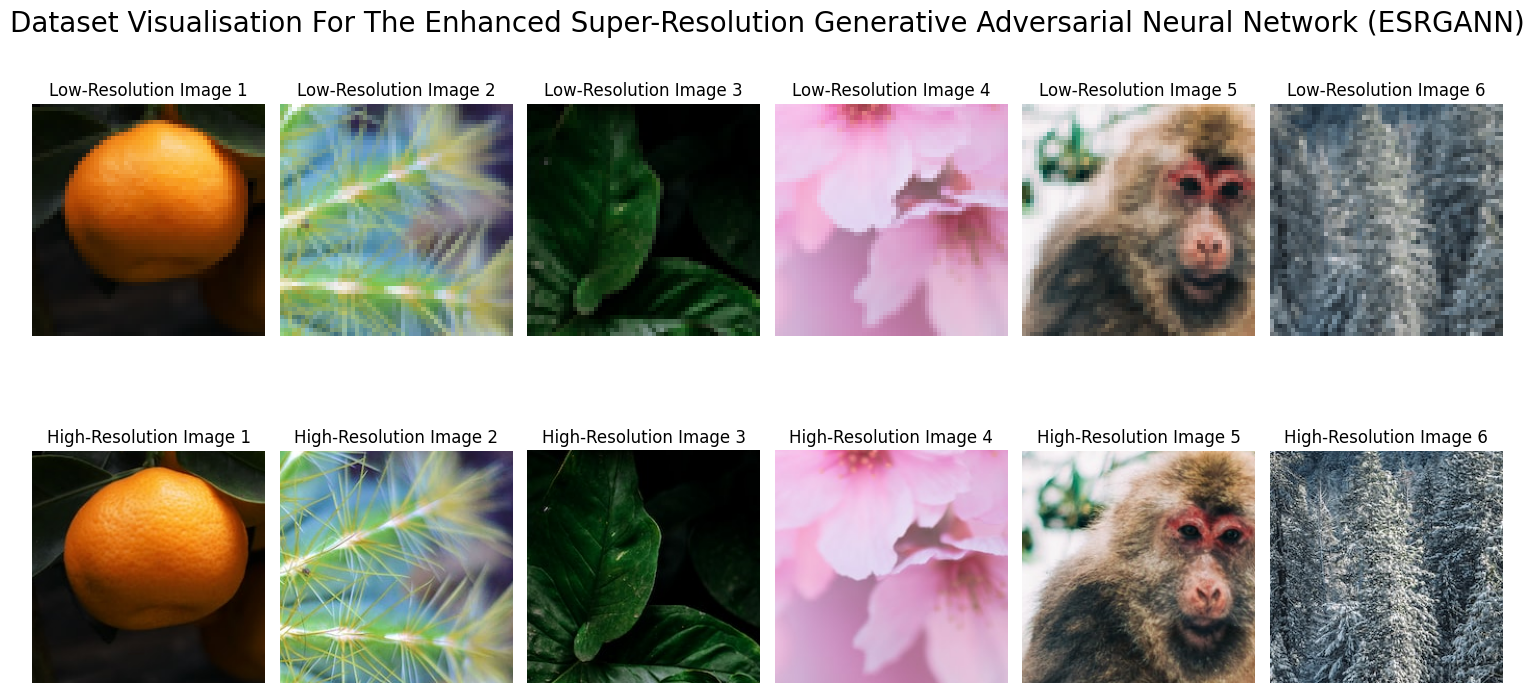

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


display_total_images = 6  # Number of images to display
plot_title = "Dataset Visualisation For The Enhanced Super-Resolution Generative Adversarial Neural Network (ESRGANN)"

# Create a figureure with 2 rows and display_total_images columns
figure, axis = plt.subplots(2, display_total_images, figsize=(15, 8))

# Loop to display the images
for i in range(display_total_images):
    low_resolution_image, high_resolution_image = training_dataset[i]

    # Convert the tensors to numpy arrays and transpose the dimensions for visualization
    low_resolution_image_np = low_resolution_image.numpy().transpose((1, 2, 0))
    high_resolution_image_np = high_resolution_image.numpy().transpose((1, 2, 0))

    # Show the low-resolution image in the first row
    axis[0, i].imshow(low_resolution_image_np)
    axis[0, i].set_title(f"Low-Resolution Image {i + 1}")
    axis[0, i].axis("off")

    # Show the high-resolution image in the second row
    axis[1, i].imshow(high_resolution_image_np)
    axis[1, i].set_title(f"High-Resolution Image {i + 1}")
    axis[1, i].axis("off")

plt.tight_layout()                      # Adjust the layout
plt.suptitle(plot_title, fontsize=20)   # Set a title for the entire figure
plt.show()                              # Display the figureure

# 2. Building the model
1. Setting up the network
2. Setting up the Loss Function

<br>

#### 2.1 Setting up the nework
Following network will be the implementation of the ESRGan Nework proposed by ESRGAN Research Paper
![link img](https://esrgan.readthedocs.io/en/latest/_images/architecture.png)

In [ ]:
print("Downloading Module: Piqa".center(167, '-'))

!pip install piqa

print("Successfully Downloaded Module: Piqa".center(167, '-') + "\n")
import torch
import piqa
import pickle
import warnings
import numpy as np
import pandas as pd
import torch.optim as optim
import torchvision.utils as utils
import torchvision.models as models

warnings.filterwarnings("ignore")

from torch import nn
from torchsummary import summary
from PIL import Image
from math import log10
from torchvision import utils
from skimage.metrics import (
    structural_similarity as ssim,
    peak_signal_noise_ratio as psnr
)
from torch.autograd import Variable
from torchvision.models import vgg19


# from torchvision.utils import save_image
# from albumentations.pytorch import ToTensorV2
# from os.path import join
# from os import listdir
# from torchvision.transforms.functional import to_pil_image, to_tensor

print(f"Piqa Version:           {piqa.__version__}" + "\n" +
      f"Numpy Version:          {np.__version__}" + "\n" +
      f"Pandas Version:         {pd.__version__}" + "\n" +
      f"Albumentations Version: {Album.__version__}")

------------------------------------------------------------------------Downloading Module: Piqa-----------------------------------------------------------------------
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-m

In [ ]:
# Definition of a convolutional block with optional activation
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        # 2D Convolution
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        # LeakyReLU activation if use_act is True, otherwise no activation
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))

In [ ]:
# Definition of an upsample block with convolution and activation
class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        # Upsample by the scale factor
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        # 2D Convolution
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        # LeakyReLU activation
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))

In [ ]:
# Definition of a dense residual block
class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        # Create 5 convolutional blocks
        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x

In [ ]:
# Definition of a recursive residual dense block
class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        # Three dense residual blocks
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x

In [ ]:
# Definition of the generator
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        # Initial convolution
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        # Residual blocks
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        # Convolution after the residual blocks
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        # Upsample blocks
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        # Final convolutions
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)

In [ ]:
# Check if a GPU is available and move the models to the appropriate device
generator = Generator().to(DEVICE)

# Print summaries
summary(generator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
            Conv2d-2           [-1, 32, 64, 64]          18,464
         LeakyReLU-3           [-1, 32, 64, 64]               0
         ConvBlock-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]          27,680
         LeakyReLU-6           [-1, 32, 64, 64]               0
         ConvBlock-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]          36,896
         LeakyReLU-9           [-1, 32, 64, 64]               0
        ConvBlock-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]          46,112
        LeakyReLU-12           [-1, 32, 64, 64]               0
        ConvBlock-13           [-1, 32, 64, 64]               0
           Conv2d-14           [-1, 64,

In [ ]:
# Definition of the discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True,
                ),
            )
            in_channels = feature

        # Convolutional blocks
        self.blocks = nn.Sequential(*blocks)
        # Final classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

In [ ]:
# Function to initialize model weights
def initialize_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

In [ ]:
# Check if a GPU is available and move the models to the appropriate device
discriminator = Discriminator().to(DEVICE)

# Print summary
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
         LeakyReLU-2           [-1, 64, 64, 64]               0
         ConvBlock-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
         LeakyReLU-5           [-1, 64, 32, 32]               0
         ConvBlock-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         LeakyReLU-8          [-1, 128, 32, 32]               0
         ConvBlock-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
        LeakyReLU-11          [-1, 128, 16, 16]               0
        ConvBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        LeakyReLU-14          [-1, 256,

#### 2.2 Setting up the Loss function (Generator| Discriminator)

In [ ]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained VGG19 model with weights
        self.vgg = models.vgg19(pretrained=True).features[:35].eval().to(DEVICE)

        # Freeze all VGG parameters
        for param in self.vgg.parameters():
            param.requires_grad = False

        # Define the loss function (MSE loss)
        self.loss = nn.MSELoss()

    def forward(self, input, target):
        # Pass input and target images through VGG network to get features
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)

        # Calculate the MSE loss between VGG features of input and target images
        return self.loss(vgg_input_features, vgg_target_features)


In [ ]:
# Initialize SSIM from piqa
ssim_calculator = piqa.SSIM().to(DEVICE)  # Assuming DEVICE is defined somewhere in your code

# Initializing SSIM from piqa
ssim = piqa.SSIM().to(DEVICE)

# 3. Train The model

#### 3.1 Utility functions for traning the model

In [ ]:
# Function to calculate gradient penalty for Wasserstein GAN with gradient penalty (WGAN-GP)
def gradient_penalty(critic, real, fake, device):
    """
    Calculate gradient penalty for Wasserstein GAN with gradient penalty (WGAN-GP).

    Parameters:
    - critic (nn.Module): The critic (discriminator) model.
    - real (torch.Tensor): Batch of real images.
    - fake (torch.Tensor): Batch of fake images.
    - device (torch.device): Device to perform calculations on.

    Returns:
    - gradient_penalty (torch.Tensor): Calculated gradient penalty.
    """
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(DEVICE)  # Generate random alpha for interpolation
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)  # Interpolate between real and fake images
    interpolated_images.requires_grad_(True)  # Set requires_grad to True for gradient calculation

    # Calculate critic scores for interpolated images
    mixed_scores = critic(interpolated_images)

    # Compute gradients of the scores with respect to the interpolated images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)  # Flatten the gradient tensor
    gradient_norm = gradient.norm(2, dim=1)  # Calculate L2 norm of gradients
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)  # Compute gradient penalty

    return gradient_penalty

Loss Functions in ESRGAN


*   Discriminator Loss: The discriminator's job is to distinguish between real high-resolution images and the images generated by the generator. The discriminator loss typically involves a binary cross-entropy loss, comparing the discriminator's predictions for real images against 1 (real) and for generated images against 0 (fake).


*  Generator Loss: The generator's goal is to create high-resolution images that the discriminator considers to be real. The generator loss often includes several components: Adversarial Loss, Perceptual Loss


In [ ]:
# Initialize the Generator and Discriminator
gen = Generator(in_channels=3).to(DEVICE)  # Initialize Generator with 3 input channels (RGB images) and move it to DEVICE (GPU if available)
disc = Discriminator(in_channels=3).to(DEVICE)  # Initialize Discriminator with 3 input channels (RGB images) and move it to DEVICE

initialize_weights(gen)  # Initialize weights of the Generator for stability

# Create optimizers for both models
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))  # Adam optimizer for Generator with specified learning rate and betas
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))  # Adam optimizer for Discriminator with specified learning rate and betas

# L1 Loss function for pixel-wise differences between generated and target images
l1 = nn.L1Loss()

# Set Generator and Discriminator to training mode
gen.train()
disc.train()

# VGG Loss for perceptual loss using a pre-trained VGG network
vgg_loss = VGGLoss()

# GradScaler objects for gradient scaling in mixed precision training
g_scaler = torch.cuda.amp.GradScaler()  # GradScaler for Generator
d_scaler = torch.cuda.amp.GradScaler()  # GradScaler for Discriminator

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 223MB/s]


In [ ]:
class ModelManager:
    def __init__(self, netG, netD, optimizerG, optimizerD, device):
        """
        Initializes the ModelManager with the necessary components for training.

        Parameters:
        - netG (nn.Module): Generator network.
        - netD (nn.Module): Discriminator network.
        - optimizerG (torch.optim.Optimizer): Optimizer for the generator.
        - optimizerD (torch.optim.Optimizer): Optimizer for the discriminator.
        - device (torch.device): Device to run the model on (CPU or GPU).
        """
        self.netG = netG
        self.netD = netD
        self.optimizerG = optimizerG
        self.optimizerD = optimizerD
        self.device = device

    def load_checkpoints(self, gen_checkpoint_path, disc_checkpoint_path):
        """
        Loads the generator and discriminator checkpoints from disk.

        Parameters:
        - gen_checkpoint_path (str): Path to the generator checkpoint file.
        - disc_checkpoint_path (str): Path to the discriminator checkpoint file.
        """
        print("=> Loading checkpoint")

        # Load the checkpoint from the specified file:
        checkpoint = torch.load(gen_checkpoint_path, map_location=self.device)
        checkpoint = torch.load(disc_checkpoint_path, map_location=self.device)

        # Load the model's state_dict from the checkpoint:
        self.netG.load_state_dict(checkpoint)
        self.netD.load_state_dict(checkpoint)


    def save_checkpoint(self, model, filename="my_checkpoint.pth.tar"):
        """
        Saves a PyTorch model checkpoint.

        Parameters:
        - model (nn.Module): The PyTorch model to save.
        - filename (str): Name of the file to save the checkpoint (default: "my_checkpoint.pth.tar").
        """
        checkpoint = model.state_dict()     # Get the state_dict of the model

        torch.save(checkpoint, filename)    # Save the checkpoint to the specified file

    def train_epoch(self, gen, disc, training_loader, device, lambda_gp, opt_disc, d_scaler, opt_gen, g_scaler, epoch,
                    start_epoch, num_epochs, batch_accum=1):
        """Train the model for one epoch"""
        train_bar = tqdm(training_loader)
        running_results = {
            "Batch Sizes": 0,
            "Discriminator Loss": 0,
            "Generator Loss": 0,
            "PSNR": 0,
            "SSIM": 0
        }

        for idx, (low_res, high_res) in enumerate(train_bar):
            batch_size = low_res.size(0)
            running_results["Batch Sizes"] += batch_size

            high_res = high_res.to(device)
            low_res = low_res.to(device)

            fake = gen(low_res)

            # Train the discriminator
            loss_critic, gp = TrainingManager.train_discriminator(
                disc, gen, high_res, fake, opt_disc, d_scaler, lambda_gp, device
            )

            # Train the generator
            gen_loss, l1_loss, adversarial_loss, loss_for_vgg = TrainingManager.train_generator(
                disc, gen, fake, high_res, opt_gen, g_scaler
            )

                # Ensure the values are in the range [0, 1]
            fake = torch.clamp(fake, 0, 1)
            high_res = torch.clamp(high_res, 0, 1)

            # Convert tensors to numpy arrays
            fake_np = fake.detach().cpu().numpy().transpose(0, 2, 3, 1)
            high_res_np = high_res.detach().cpu().numpy().transpose(0, 2, 3, 1)

            # Calculate PSNR and SSIM for each image in the batch
            batch_psnr = 0
            batch_ssim = 0
            for i in range(batch_size):
                batch_psnr += psnr(fake_np[i], high_res_np[i], data_range=1)
                batch_ssim += ssim(fake_np[i], high_res_np[i], win_size=11, multichannel=True, data_range=1)

            batch_psnr /= batch_size
            batch_ssim /= batch_size

            # Update running results with batch metrics
            running_results["Discriminator Loss"] += loss_critic.item() * batch_size
            running_results["Generator Loss"] += gen_loss.item() * batch_size
            running_results["PSNR"] += batch_psnr * batch_size
            running_results["SSIM"] += batch_ssim * batch_size

            if (idx + 1) % 100 == 0:
                pass  # Optional: Add code to save intermediate checkpoints if desired

            train_bar.set_postfix(
                gp=gp.item(),
                critic=loss_critic.item(),
                l1=l1_loss.item(),
                vgg=loss_for_vgg.item(),
                adversarial=adversarial_loss.item()
            )

        # Average results over the epoch
        for key in running_results:
            running_results[key] /= running_results["Batch Sizes"]

        return running_results

    def validate(self,gen,valid_loader, device):
        """Validates the model on the validation dataset"""
        gen.eval()
        val_bar = tqdm(valid_loader)
        val_results = {
            "MSE": 0,
            "PSNR": 0,
            "SSIM": 0,
            "Batch Sizes": 0
        }

        with torch.no_grad():
            for val_lr, val_hr_restore, val_hr in val_bar:
                batch_size = val_lr.size(0)
                val_results["Batch Sizes"] += batch_size

                # Move data to device
                lr = val_lr.to(device)  # Low-resolution images
                hr = val_hr.to(device)  # High-resolution target images

                # Generate super-resolution image
                sr = gen(lr)

                # Ensure the values are in the range [0, 1]
                sr = torch.clamp(sr, 0, 1)
                hr = torch.clamp(hr, 0, 1)

                # Convert tensors to numpy arrays
                sr_np = sr.cpu().numpy().transpose(0, 2, 3, 1)
                hr_np = hr.cpu().numpy().transpose(0, 2, 3, 1)

                # Calculate metrics
                batch_mse = ((sr - hr) ** 2).data.mean().item()  # Mean Squared Error (MSE)
                val_results["MSE"] += batch_mse * batch_size

                batch_psnr = 0
                batch_ssim = 0
                for i in range(batch_size):
                    batch_psnr += psnr(hr_np[i], sr_np[i], data_range=1)  # Peak Signal-to-Noise Ratio (PSNR)
                    batch_ssim += ssim(hr_np[i], sr_np[i], batch_size=11, multichannel=True, data_range=1)  # Structural Similarity Index (SSIM)

                batch_psnr /= batch_size
                batch_ssim /= batch_size

                val_results["PSNR"] += batch_psnr * batch_size
                val_results["SSIM"] += batch_ssim * batch_size

                val_bar.set_postfix(mse=batch_mse, psnr=batch_psnr, ssim=batch_ssim)

        # Average results
        for key in val_results:
            val_results[key] /= val_results["Batch Sizes"]

        gen.train()
        return val_results

In [ ]:
class TrainingManager:
    def __init__(self, model_manager, train_loader, valid_loader, num_epochs, start_epoch=1):
        self.model_manager = model_manager
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.num_epochs = num_epochs
        self.start_epoch = start_epoch

        # Dynamically generate results path based on last epoch
        self.results_path = CHECKPOINT_WEIGHTS + f"Training Results Epoch_{start_epoch-1}.pkl"

        # Initialize results or load existing results if continuing training
        if os.path.exists(self.results_path):
            print("loading the previous result...")
            with open(self.results_path, 'rb') as f:
                self.results = pickle.load(f)
        else:
            self.results = {
                "Discriminator Loss": [],
                "Generator Loss": [],
                "Discriminator Score": [],
                "Generator Score": [],
                "PSNR": [],
                "SSIM": []
            }

        # Calculate total epochs for plotting
        self.total_epochs = len(self.results["Discriminator Loss"]) + self.num_epochs

    def save_results(self, running_results, valing_results, epoch):
        """Save training and validation results to a file"""
        self.results["Discriminator Loss"].append(
            running_results["Discriminator Loss"] / running_results["Batch Sizes"]
        )
        self.results["Generator Loss"].append(running_results["Generator Loss"] / running_results["Batch Sizes"])


        if torch.is_tensor(running_results["PSNR"]):
            print("added")
            self.results["PSNR"].append(running_results["PSNR"]["PSNR"].detach().cpu().item())
        else:
            self.results["PSNR"].append(running_results["PSNR"])

        if torch.is_tensor(running_results["SSIM"]):
            self.results["SSIM"].append(running_results["SSIM"].detach().cpu().item())
        else:
            self.results["SSIM"].append(running_results["SSIM"])

        if epoch == self.num_epochs:
            filename_disc = CHECKPOINT_DISCRIMINATOR_WEIGHTS + f"/Discriminator Epoch_{epoch}.pth"
            filename_gen = CHECKPOINT_GENERATOR_WEIGHTS + f"/Generator Epoch_{epoch}.pth"
            self.model_manager.save_checkpoint(self.model_manager.netD, filename_disc)
            self.model_manager.save_checkpoint(self.model_manager.netG, filename_gen)

            # Save results to file
            self.saving_path = CHECKPOINT_WEIGHTS + f"/Training Results Epoch_{epoch}.pkl"
            with open(self.saving_path, 'wb') as f:
                pickle.dump(self.results, f)

            self.plot_performance()

    def plot_performance(self):
        epochs_range = range(1, len(self.results["Discriminator Loss"]) + 1)
        plt.style.use("seaborn-v0_8-deep")
        plot_title = "Visualizing the Training Performance of the ESRGAN Model"

        plt.figure(figsize=(30, 11), dpi=500, facecolor="darkseagreen")
        plt.style.use("seaborn-v0_8-deep")

        plt.subplot(1, 2, 1)
        plt.plot(
            epochs_range, self.results["Discriminator Loss"], "o--", label="Discriminator Loss", color="mediumblue"
        )
        plt.plot(epochs_range, self.results["Generator Loss"], "s:", label='Generator Loss', color="orangered")
        plt.title('Training and Validation Loss', fontsize=35, color="darkblue")
        plt.xlabel('Epochs', fontsize=20, color="bisque")
        plt.xticks(fontsize=15)
        plt.ylabel('Loss', fontsize=20, color="bisque")
        plt.yticks(fontsize=15)
        plt.legend(fontsize=20)
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.results["PSNR"], "o--", label="PSNR", color="mediumblue")
        plt.plot(epochs_range, self.results["SSIM"], "s:", label="SSIM", color="orangered")
        plt.title("PSNR and SSIM Over Epochs", fontsize=35, color="darkblue")
        plt.xlabel("Epochs", fontsize=20, color="bisque")
        plt.xticks(fontsize=15)
        plt.ylabel("Metrics", fontsize=20, color="bisque")
        plt.yticks(fontsize=15)
        plt.legend(fontsize=20)
        plt.grid(True)

        plt.suptitle(plot_title, fontsize=40, color="dimgray")
        plt.tight_layout()
        plt.show()
        plt.close()

    def train_discriminator(disc, gen, real_images, fake_images, optimizer, scaler, lambda_gp, device):
        """Train the discriminator"""
        with torch.cuda.amp.autocast():
            critic_real = disc(real_images)
            critic_fake = disc(fake_images.detach())
            gp = gradient_penalty(disc, real_images, fake_images, device=device)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp

        optimizer.zero_grad()
        scaler.scale(loss_critic).backward()
        scaler.step(optimizer)
        scaler.update()
        return loss_critic, gp

    def train_generator(disc, gen, fake_images, real_images, optimizer, scaler):
        """Train the generator"""
        with torch.cuda.amp.autocast():
            fake_out = disc(fake_images).mean()  # Forward pass fake images through updated discriminator
            l1_loss = 1e-2 * l1(fake_images, real_images)
            adversarial_loss = 5e-3 * -torch.mean(disc(fake_images))
            loss_for_vgg = vgg_loss(fake_images, real_images)
            gen_loss = l1_loss + loss_for_vgg + adversarial_loss

        optimizer.zero_grad()
        scaler.scale(gen_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        return gen_loss, l1_loss, adversarial_loss, loss_for_vgg

    def train(self):
          for epoch in range(self.start_epoch, self.num_epochs+1):
              print(f"Epoch {epoch } Training")
              running_results = self.model_manager.train_epoch(
                  gen, disc, training_loader, DEVICE, LAMBDA_GRADIENT_PENALTY, opt_disc, d_scaler, opt_gen, g_scaler,
                  epoch, start_epoch, self.num_epochs, batch_accum=1
              )
              valing_results = self.model_manager.validate(gen,valid_loader,DEVICE)

              self.save_results(running_results, valing_results, epoch)
              generate_and_save_images(valid_loader, gen, epoch, generated_images_path)
              print(f"Epoch {epoch } completed")

In [63]:
# Function to generate images using the loaded model
def generate_images(data_loader, model):
    """
    Generates high-resolution images using the ESRGAN model on a batch of low-resolution images.

    Parameters:
    - data_loader (DataLoader): DataLoader providing the low-resolution images.
    - model (nn.Module): The loaded ESRGAN model.

    Returns:
    - low_res (numpy.ndarray): Low-resolution input image.
    - high_res (numpy.ndarray): High-resolution ground truth image.
    - gen_res (numpy.ndarray): Generated high-resolution image.
    """
    with torch.no_grad():  # Disable gradient calculation for efficiency
        # Randomly select one example from the data loader
        random_batch = next(iter(data_loader))
        lr_image, hr_restore_img, hr_image = random_batch  # Unpack the batch

        # Generate a high-resolution image from the low-resolution input
        generated_image = model(lr_image.to(DEVICE)).to("cpu")  # Move input to device, generate, move output to CPU

        # Convert the tensors to NumPy arrays
        low_res = lr_image.squeeze(0).permute(1, 2, 0).numpy()  # Low-resolution image
        gen_res = generated_image.squeeze(0).permute(1, 2, 0).numpy()  # Generated high-resolution image
        high_res = hr_image.squeeze(0).permute(1, 2, 0).numpy()  # Ground truth high-resolution image

        return (low_res, high_res, gen_res)  # Return the images

def visualize_images(data_loader, model):
    """
    Plots the low-resolution, high-resolution (ground truth), and generated high-resolution images in a 3x3 grid.

    Parameters:
    - data_loader (DataLoader): DataLoader providing the low-resolution images.
    - model (nn.Module): The loaded SRGAN model.
    """
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Create a subplot with 3 rows and 3 columns

    for i in range(3):
        low_res, high_res, gen_res = generate_images(data_loader, model)

        axs[i, 0].imshow(low_res)  # Show the low-resolution image
        axs[i, 0].set_title("Low Resolution")  # Set the title
        axs[i, 0].axis("off")  # Turn off the axis

        axs[i, 1].imshow(high_res)  # Show the high-resolution ground truth image
        axs[i, 1].set_title("High Resolution")  # Set the title
        axs[i, 1].axis("off")  # Turn off the axis

        axs[i, 2].imshow(gen_res)  # Show the generated high-resolution image
        axs[i, 2].set_title("Generated High Resolution")  # Set the title
        axs[i, 2].axis("off")  # Turn off the axis

    plt.tight_layout()
    plt.show()  # Display the plot


def generate_and_save_images(data_loader, model, epoch, output_dir):
    """
    Generates low-resolution, high-resolution (ground truth), and generated high-resolution images and saves them
    to a specified directory based on the current epoch.

    Parameters:
    - data_loader (DataLoader): DataLoader providing the low-resolution images.
    - model (nn.Module): The loaded SRGAN model.
    - epoch (int): Current epoch number.
    - output_dir (str): Directory path where images will be saved.

    Returns:
    - None
    """
    # Create directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)

    for i in range(3):
        low_res, high_res, gen_res = generate_images(data_loader, model)

        fig, axs = plt.subplots(1, 3, figsize=(30, 10))  # Increase size by doubling width and height
        axs[0].imshow(low_res)
        axs[0].set_title("Low Resolution", fontsize=20)  # Increase font size for title
        axs[0].axis('off')

        axs[1].imshow(high_res)
        axs[1].set_title("High Resolution", fontsize=20)  # Increase font size for title
        axs[1].axis('off')

        axs[2].imshow(gen_res)
        axs[2].set_title("Generated High Resolution", fontsize=20)  # Increase font size for title
        axs[2].axis('off')

        plt.tight_layout()

        # Save the plot as an image file
        save_path = os.path.join(output_dir, f"Generated_image_epoch_{i}.png")
        plt.savefig(save_path)
        plt.close()  # Close the plot to free up memory

In [ ]:
# Initialize data loader
train_loader, valid_loader = training_loader,validation_loader

# Assuming model_manager, train_loader, valid_loader, optimizerG, optimizerD, generator_criterion, and DEVICE are defined
model_manager = ModelManager(gen, disc, opt_gen, opt_disc, DEVICE)

# [First Training]

In [ ]:
from skimage.metrics import (
    structural_similarity as ssim,
    peak_signal_noise_ratio as psnr
)

In [61]:
if __name__ == "__main__":
    # Additional epochs to train the model
    additional_epochs = 1

    last_epoch = 0  # Initialize last epoch to 0

    # Define the list of epochs for training stages
    start_epoch = last_epoch + 1
    total_epochs = last_epoch + additional_epochs

    # Initialize training manager
    training_manager = TrainingManager(
        model_manager,
        train_loader,
        valid_loader,
        total_epochs,
        start_epoch=start_epoch,
    )

    training_manager.train()

Epoch 1 Training


100%|██████████| 238/238 [01:14<00:00,  3.18it/s, mse=0.0351, psnr=14.6, ssim=0.28]


Epoch 1 completed


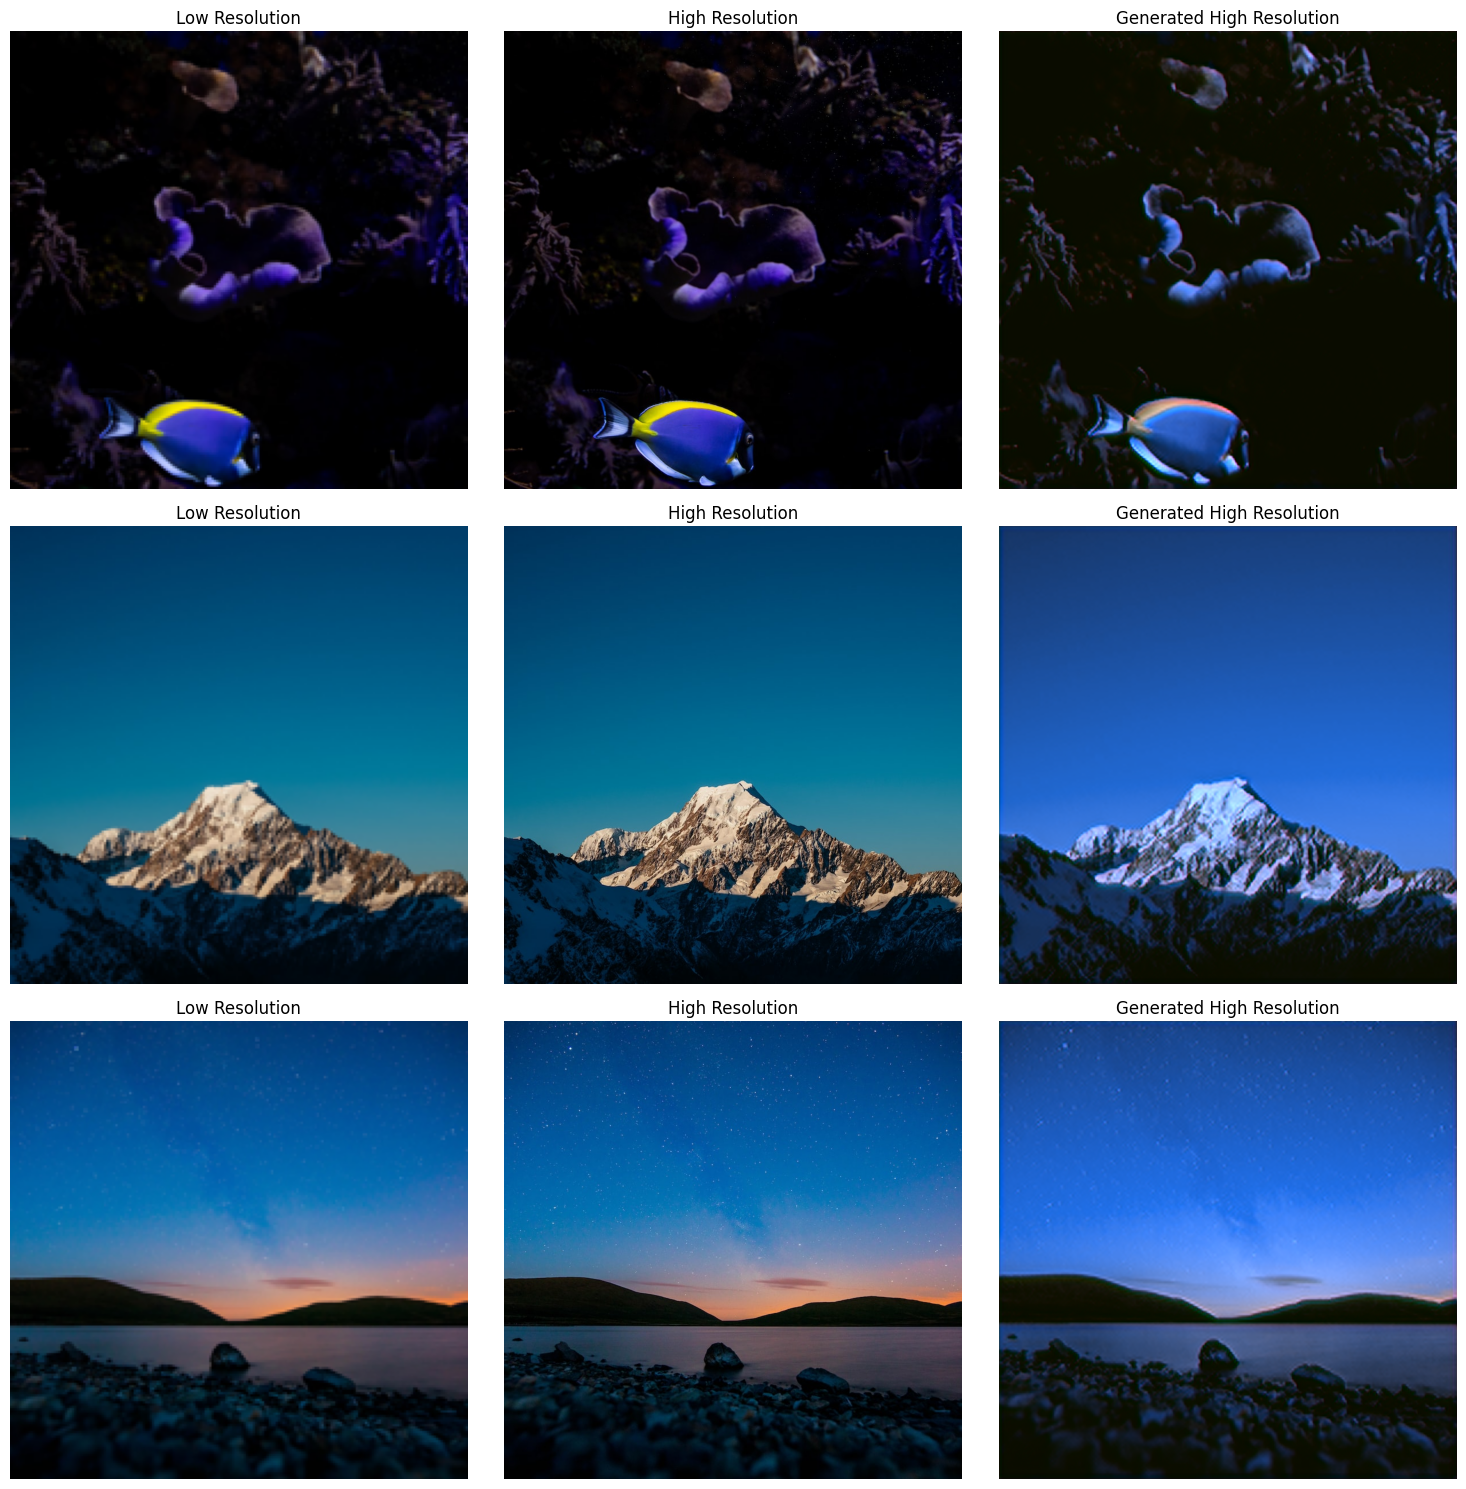

In [64]:
visualize_images(valid_loader, gen)